## 사용하는 라이브러리 가져오기

In [1]:
from third_party.midi_processor.processor import Event, SplitNote, _merge_note, encode_midi, encode_midi_JE, _control_preprocess, _note_preprocess, _divide_note, _make_time_sift_events, _snote2events, _snote2events_JE, _event_seq2snote_seq, _event_seq2snote_seq_JE, encode_midi, encode_midi_JE
import pretty_midi
import random

In [2]:
import os
import glob
# 데이터 디렉토리 path 지정하기
dir_path = '/home/bang/다운로드/maestro-v2.0.0-midi/maestro_midi'

set1 = glob.glob(os.path.join(dir_path, '*'))

In [3]:
# data path 지정하기
# file_path = '/home/bang/PycharmProjects/POP909-Dataset/pop909_midi/562.mid'   # controlChange가 없는 데이터
file_path = '/home/bang/PycharmProjects/POP909-Dataset/pop909_midi/002.mid'

## encoding 비교하기!

In [30]:
print("음차의 duration 사용된 토큰 개수 비교하기")
for mid in set1:
    interval = encode_midi_JE(mid, logspace = True)
    print("interval, duration:", len(set([i for i in interval if 254 < i < 355])))

음차의 duration 사용된 토큰 개수 비교하기
interval, duration: 31
interval, duration: 32
interval, duration: 31
interval, duration: 29
interval, duration: 32
interval, duration: 31
interval, duration: 32
interval, duration: 31
interval, duration: 32
interval, duration: 32
interval, duration: 31
interval, duration: 0
interval, duration: 31


KeyboardInterrupt: 

In [29]:
print("midi-like랑 음차의 note_on 개수 비교하기")
for mid in set1:
    midi_like = encode_midi(mid)
    interval = encode_midi_JE(mid, True)
    print("midi_like :",len(set([i for i in midi_like if i < 128])), ", interval:", len(set([i for i in interval if i < 255])))

midi-like랑 음차의 note_on 개수 비교하기
midi_like : 42 , interval: 68
midi_like : 81 , interval: 102
midi_like : 39 , interval: 48
midi_like : 56 , interval: 87
midi_like : 75 , interval: 125
midi_like : 68 , interval: 94
midi_like : 81 , interval: 129
midi_like : 67 , interval: 96
midi_like : 73 , interval: 120
midi_like : 79 , interval: 136
midi_like : 73 , interval: 77
midi_like : 0 , interval: 0
midi_like : 62 , interval: 93


KeyboardInterrupt: 

In [32]:
for mid in set1:
    midi_like = encode_midi(mid)
    interval = encode_midi_JE(mid, True)
    print("midi_like time_shift:",len(set([i for i in midi_like if 255 < i < 355])), ", interval:", len(set([i for i in interval if  354 < i < 455])))

midi_like time_shift: 56 , interval: 65
midi_like time_shift: 76 , interval: 81
midi_like time_shift: 15 , interval: 16
midi_like time_shift: 40 , interval: 43
midi_like time_shift: 93 , interval: 96
midi_like time_shift: 88 , interval: 90
midi_like time_shift: 76 , interval: 91
midi_like time_shift: 59 , interval: 65
midi_like time_shift: 99 , interval: 98
midi_like time_shift: 85 , interval: 89
midi_like time_shift: 29 , interval: 29
midi_like time_shift: 0 , interval: 0
midi_like time_shift: 80 , interval: 79
midi_like time_shift: 97 , interval: 97


KeyboardInterrupt: 

In [31]:
print("midi-like와 음차의 총 사용된 토큰 비교하기")
for mid in set1:
    midi_like = encode_midi(mid)
    interval = encode_midi_JE(mid, True)
    print("midi_like :",len(set(midi_like)), ", interval:", len(set(interval)))

midi-like와 음차의 총 사용된 토큰 비교하기
midi_like : 165 , interval: 188
midi_like : 269 , interval: 245
midi_like : 115 , interval: 117
midi_like : 178 , interval: 184
midi_like : 274 , interval: 283
midi_like : 253 , interval: 243
midi_like : 269 , interval: 282
midi_like : 220 , interval: 218
midi_like : 274 , interval: 278
midi_like : 275 , interval: 288
midi_like : 203 , interval: 164
midi_like : 0 , interval: 0
midi_like : 229 , interval: 227


KeyboardInterrupt: 

## 시작!

In [3]:
from tqdm import tqdm 

In [23]:
# 모든 음악의 duration 계산하는 코드

duration = []
for mid in tqdm(set1):
    mid = pretty_midi.PrettyMIDI(midi_file=mid)
    
    notes  = []
    events = []

    for inst in mid.instruments:
        inst_notes = inst.notes
        # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
        # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
        ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
        notes += _note_preprocess(ctrls, inst_notes)

    cur_time = 0
    cur_vel = 0

    for snote in notes:
        events += _make_time_shift_events_and_duration_JE(prev_time=cur_time, note_on_time=snote.start)
        events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=snote.pitch)
        # events += _make_time_sift_events(prev_time=cur_time, post_time=snote.time)

        cur_time = snote.start
        cur_vel = snote.velocity
    #print(len( [e.value for e in events if e.type=='duration']) )
    try:
        duration += random.sample([e.value for e in events if e.type=='duration'], 1)
    except:
        duration += [e.value for e in events if e.type=='duration']
    

100%|██████████| 1281/1281 [05:23<00:00,  3.96it/s]


In [35]:
len(duration)

1272

## plot 그리기

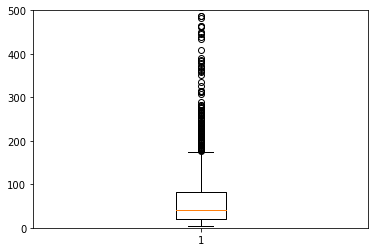

In [27]:
import matplotlib.pyplot as plt
plt.boxplot(duration)
plt.ylim([0, 500])
plt.show()

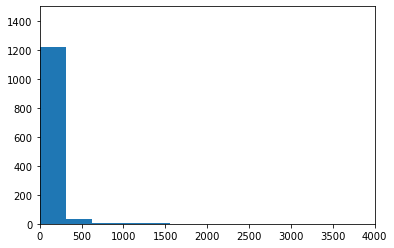

In [40]:
import matplotlib.pyplot as plt
plt.hist(duration)
plt.ylim([0, 1500])
plt.xlim([0, 4000])
plt.show()

## encoding 방법 고안하기

In [3]:
events = []
notes = []
mid = pretty_midi.PrettyMIDI(midi_file=file_path)

In [9]:
sum = 0

for mid in set1:
    mid = pretty_midi.PrettyMIDI(midi_file=mid)
    
    notes  = []
    events = []
    duration = []

    for inst in mid.instruments:
        inst_notes = inst.notes
    # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
    # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
    ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    # print([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    notes += _note_preprocess(ctrls, inst_notes)

    dnotes = _divide_note(notes)

    cur_time = 0
    cur_vel = 0

    for snote in notes:
        events += _make_time_sift_events(prev_time=cur_time, post_time=snote.start)
        # events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=snote.pitch)
        # events += _make_time_sift_events(prev_time=cur_time, post_time=snote.time)

        cur_time = snote.start
        cur_vel = snote.velocity
        
        duration += [e.value for e in events if e.type=='duration']

    event2int = [e.to_int_JE() for e in events]
    
    print(len(set([i for i in event2int if i < 256])))
    

AttributeError: 'Note' object has no attribute 'time'

In [ ]:
print("note_on을 몇 개 썼을까용??", sum/len(set1))

Error: Session cannot generate requests

In [57]:
notes  = []
events = []
duration = []

for inst in mid.instruments:
    inst_notes = inst.notes
    # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
    # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
    ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    # print([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    notes += _note_preprocess(ctrls, inst_notes)

dnotes = _divide_note(notes)

cur_time = 0
cur_vel = 0

for snote in notes:
    events += _make_time_sift_events(prev_time=cur_time, post_time=snote.start)
    events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=snote.pitch)
    # events += _make_time_sift_events(prev_time=cur_time, post_time=snote.time)

    cur_time = snote.start
    cur_vel = snote.velocity
    
    duration += [e.value for e in events if e.type=='duration']

event2int = [e.to_int_JE() for e in events]

In [63]:
print(len(set([i for i in event2int if i < 256])))

30


In [52]:
dnotes[:5]

[<[SNote] time: 3.764113154166667 type: note_on, value: 78, velocity: 114>,
 <[SNote] time: 4.038306720833334 type: note_off, value: 78, velocity: None>,
 <[SNote] time: 4.008064783333333 type: note_on, value: 76, velocity: 105>,
 <[SNote] time: 4.183468020833334 type: note_off, value: 76, velocity: None>,
 <[SNote] time: 4.254032541666667 type: note_on, value: 75, velocity: 117>]

In [18]:
events[:5]

[]

In [19]:
event2int[:10]

[]

## Decoding 방법 고안하기

In [51]:
def _event_seq2snote_seq(event_sequence):
    timeline = 0
    velocity = 0
    snote_seq = []

    for event in event_sequence:
        if event.type == 'time_shift':
            timeline += ((event.value+1) / 100)
        if event.type == 'velocity':
            velocity = event.value * 4
        else:
            snote = SplitNote(event.type, timeline, event.value, velocity)
            snote_seq.append(snote)
    return snote_seq

def _merge_note(snote_sequence):
    note_on_dict = {}
    result_array = []

    for snote in snote_sequence:
        # print(note_on_dict)
        if snote.type == 'note_on':
            note_on_dict[snote.value] = snote
        elif snote.type == 'note_off':
            try:
                on = note_on_dict[snote.value]
                off = snote
                if off.time - on.time == 0:
                    continue
                result = pretty_midi.Note(on.velocity, snote.value, on.time, off.time)
                result_array.append(result)
            except:
                print('info removed pitch: {}'.format(snote.value))
    return result_array

In [52]:
event2int[:5]

[654, 654, 626, 671, 47]

In [53]:
events[:10]

[<Event type: time_shift, value: 99>,
 <Event type: time_shift, value: 99>,
 <Event type: time_shift, value: 71>,
 <Event type: velocity, value: 16>,
 <Event type: note_on, value: 47>,
 <Event type: duration, value: 92>,
 <Event type: time_shift, value: 16>,
 <Event type: velocity, value: 12>,
 <Event type: note_on, value: 54>,
 <Event type: duration, value: 78>]

In [54]:
class SplitNote:
    def __init__(self, type, time, value, velocity):
        ## type: note_on, note_off
        self.type = type
        self.time = time
        self.velocity = velocity
        self.value = value

    def __repr__(self):
        return '<[SNote] time: {} type: {}, value: {}, velocity: {}>'\
            .format(self.time, self.type, self.value, self.velocity)

In [55]:
timeline = 0
velocity = 0
duration = 0
last_pitch = 0
snote_seq = []

for event in events:
    if event.type == 'time_shift':
        timeline += ((event.value+1) / 100)
    if event.type == 'velocity':
        velocity = event.value * 4
    if event.type == 'duration':
        duration = ((event.value+1) / 100)
        snote = SplitNote('note_off', timeline+duration, last_pitch, velocity)
        snote_seq.append(snote)
    else:
        last_pitch = event.value
        snote = SplitNote(event.type, timeline, event.value, velocity)
        snote_seq.append(snote)
a = snote_seq

In [56]:
a[:5]

[<[SNote] time: 1.0 type: time_shift, value: 99, velocity: 0>,
 <[SNote] time: 2.0 type: time_shift, value: 99, velocity: 0>,
 <[SNote] time: 2.7199999999999998 type: time_shift, value: 71, velocity: 0>,
 <[SNote] time: 2.7199999999999998 type: velocity, value: 16, velocity: 64>,
 <[SNote] time: 2.7199999999999998 type: note_on, value: 47, velocity: 64>]

In [57]:
def _merge_note(snote_sequence):
    note_on_dict = {}
    result_array = []

    for snote in snote_sequence:
        # print(note_on_dict)
        if snote.type == 'note_on':
            note_on_dict[snote.value] = snote
        elif snote.type == 'note_off':
            try:
                on = note_on_dict[snote.value]
                off = snote
                if off.time - on.time == 0:
                    continue
                result = pretty_midi.Note(on.velocity, snote.value, on.time, off.time)
                result_array.append(result)
            except:
                print('info removed pitch: {}'.format(snote.value))
    return result_array

In [58]:
note_seq = _merge_note(a)

In [59]:
notes[:5]

[Note(start=2.722215, end=3.648602, pitch=47, velocity=65),
 Note(start=2.888882, end=3.679157, pitch=54, velocity=49),
 Note(start=3.055548, end=3.955546, pitch=59, velocity=59),
 Note(start=3.222214, end=4.033323, pitch=66, velocity=100),
 Note(start=4.055545, end=4.884710, pitch=49, velocity=97)]

In [60]:
note_seq[:5]

[Note(start=2.720000, end=3.650000, pitch=47, velocity=64),
 Note(start=2.890000, end=3.680000, pitch=54, velocity=48),
 Note(start=3.060000, end=3.960000, pitch=59, velocity=56),
 Note(start=3.230000, end=4.040000, pitch=66, velocity=100),
 Note(start=4.060000, end=4.890000, pitch=49, velocity=96)]

## 킹갓호의 음차아이디어를 적용해보자

In [41]:
# data path 지정하기
file_path = '/home/bang/PycharmProjects/POP909-Dataset/pop909_midi/002.mid'

In [50]:
events = []
notes = []
mid = pretty_midi.PrettyMIDI(midi_file=file_path)

In [51]:
notes  = []
events = []
duration = []
last_pitch = -1

for inst in mid.instruments:
    inst_notes = inst.notes
    # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
    # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
    ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    notes += _note_preprocess(ctrls, inst_notes)

cur_time = 0
cur_vel = 0

for snote in notes:
    events += _make_time_sift_events(prev_time=cur_time, post_time=snote.start)
    if last_pitch == -1:
        events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=0)
    else:
        events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=(snote.pitch-last_pitch)+127)
    # events += _make_time_sift_events(prev_time=cur_time, post_time=snote.time)

    cur_time = snote.start
    cur_vel = snote.velocity
    
    last_pitch=snote.pitch

event2int = [e.to_int_JE() for e in events]

In [64]:
notes[:5]

[Note(start=2.722215, end=3.648602, pitch=47, velocity=65),
 Note(start=2.888882, end=3.679157, pitch=54, velocity=49),
 Note(start=3.055548, end=3.955546, pitch=59, velocity=59),
 Note(start=3.222214, end=4.033323, pitch=66, velocity=100),
 Note(start=4.055545, end=4.884710, pitch=49, velocity=97)]

In [65]:
events[:5]

[<Event type: time_shift, value: 99>,
 <Event type: time_shift, value: 99>,
 <Event type: time_shift, value: 71>,
 <Event type: velocity, value: 16>,
 <Event type: note_on, value: 0>]

In [66]:
event2int[:5]

[654, 654, 626, 671, 0]

In [67]:
# print(event_sequence)
snote_seq = _event_seq2snote_seq_JE(events)
note_seq = _merge_note(snote_seq)
note_seq.sort(key=lambda x:x.start)

In [68]:
timeline = 0
velocity = 0
duration = 0
last_pitch = 74
first_note_on = True
snote_seq = []

for event in events:
    if event.type == 'time_shift':
        timeline += ((event.value+1) / 100)
    if event.type == 'velocity':
        velocity = event.value * 4
    if event.type == 'duration':
        duration = ((event.value+1) / 100)
        snote = SplitNote('note_off', timeline+duration, last_pitch, velocity)
        snote_seq.append(snote)
    else:
        if first_note_on and event.type=='note_on':
            snote = SplitNote(event.type, timeline, last_pitch, velocity)
            first_note_on = False
        elif event.type=='note_on':
            last_pitch += event.value - 127
            snote = SplitNote(event.type, timeline, last_pitch, velocity)
        else:
            snote = SplitNote(event.type, timeline, event.value, velocity)
        snote_seq.append(snote)
        
a = snote_seq

In [69]:
a[:5]

[<[SNote] time: 1.0 type: time_shift, value: 99, velocity: 0>,
 <[SNote] time: 2.0 type: time_shift, value: 99, velocity: 0>,
 <[SNote] time: 2.7199999999999998 type: time_shift, value: 71, velocity: 0>,
 <[SNote] time: 2.7199999999999998 type: velocity, value: 16, velocity: 64>,
 <[SNote] time: 2.7199999999999998 type: note_on, value: 74, velocity: 64>]

In [70]:
note_seq = _merge_note(a)

In [76]:
notes[-10:]

[Note(start=190.388413, end=191.523132, pitch=49, velocity=106),
 Note(start=191.055078, end=191.531466, pitch=56, velocity=101),
 Note(start=191.388410, end=191.977298, pitch=65, velocity=109),
 Note(start=191.388410, end=191.977298, pitch=61, velocity=109),
 Note(start=191.917576, end=193.816182, pitch=42, velocity=104),
 Note(start=192.017576, end=193.943960, pitch=54, velocity=96),
 Note(start=192.066187, end=193.792571, pitch=49, velocity=80),
 Note(start=192.091186, end=193.934237, pitch=58, velocity=104),
 Note(start=192.152297, end=193.930071, pitch=61, velocity=87),
 Note(start=192.218964, end=193.916182, pitch=66, velocity=73)]

In [77]:
note_seq[-10:]

[Note(start=189.970000, end=191.100000, pitch=76, velocity=104),
 Note(start=190.640000, end=191.120000, pitch=83, velocity=100),
 Note(start=190.970000, end=191.560000, pitch=92, velocity=108),
 Note(start=190.970000, end=191.560000, pitch=88, velocity=108),
 Note(start=191.500000, end=193.400000, pitch=69, velocity=104),
 Note(start=191.600000, end=193.530000, pitch=81, velocity=96),
 Note(start=191.650000, end=193.380000, pitch=76, velocity=80),
 Note(start=191.670000, end=193.510000, pitch=85, velocity=104),
 Note(start=191.730000, end=193.510000, pitch=88, velocity=84),
 Note(start=191.800000, end=193.500000, pitch=93, velocity=72)]

In [73]:
events[:10]

[<Event type: time_shift, value: 99>,
 <Event type: time_shift, value: 99>,
 <Event type: time_shift, value: 71>,
 <Event type: velocity, value: 16>,
 <Event type: note_on, value: 0>,
 <Event type: duration, value: 92>,
 <Event type: time_shift, value: 16>,
 <Event type: velocity, value: 12>,
 <Event type: note_on, value: 134>,
 <Event type: duration, value: 78>]

## octave encoding

In [4]:
## 기존 인코딩 방법

events = []
notes = []
mid = pretty_midi.PrettyMIDI(midi_file=file_path)

for inst in mid.instruments:
    inst_notes = inst.notes
    # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
    # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
    ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    notes += _note_preprocess(ctrls, inst_notes)

dnotes = _divide_note(notes)

dnotes.sort(key=lambda x: x.time)
# print('sorted:')
# print(dnotes)
cur_time = 0
cur_vel = 0
for snote in dnotes:
    events += _make_time_sift_events(prev_time=cur_time, post_time=snote.time)
    events += _snote2events(snote=snote, prev_vel=cur_vel)
    # events += _make_time_sift_events(prev_time=cur_time, post_time=snote.time)

    cur_time = snote.time
    cur_vel = snote.velocity

print([e.to_int() for e in events][:5])

[355, 355, 355, 331, 384]


In [6]:
notes

[Note(start=3.764113, end=4.038307, pitch=78, velocity=114),
 Note(start=4.008065, end=4.183468, pitch=76, velocity=105),
 Note(start=4.254033, end=4.612904, pitch=75, velocity=117),
 Note(start=4.274194, end=4.947581, pitch=63, velocity=89),
 Note(start=4.274194, end=4.953629, pitch=59, velocity=78),
 Note(start=4.274194, end=5.762097, pitch=47, velocity=80),
 Note(start=4.780242, end=5.066533, pitch=75, velocity=111),
 Note(start=5.241936, end=6.223791, pitch=59, velocity=82),
 Note(start=5.241936, end=6.231855, pitch=63, velocity=87),
 Note(start=5.260081, end=5.971775, pitch=75, velocity=117),
 Note(start=5.788307, end=7.044355, pitch=54, velocity=92),
 Note(start=6.229839, end=6.377017, pitch=73, velocity=108),
 Note(start=6.272178, end=7.028226, pitch=58, velocity=71),
 Note(start=6.272178, end=7.088710, pitch=61, velocity=80),
 Note(start=6.272178, end=7.963710, pitch=42, velocity=92),
 Note(start=6.471775, end=6.826613, pitch=73, velocity=102),
 Note(start=6.955646, end=7.16532

In [27]:
# 필요한 class
DURATION = 100
NOTE_CHANGE = 255           # 0 -> 127, 127 -> 0, 0 -> 0
START_PITCH = 74

RANGE_NOTE_ON = 128
RANGE_NOTE_OFF = 128
RANGE_VEL = 32
RANGE_TIME_SHIFT = 100

OCTAVE_RANGE = 10
PITCH_RANGE = 12

OCTAVE_RANGE_INTERVAL = 19
PITCH_RANGE_INTERVAL = 23

START_IDX_OCTAVE = {
    'octave_shift': 0,                                                             # 0
    'pitch_shift':OCTAVE_RANGE,                                                    # 19
    'duration': OCTAVE_RANGE + PITCH_RANGE,                                        # 42
    'time_shift': OCTAVE_RANGE + PITCH_RANGE + DURATION,                           # 142
    'velocity': OCTAVE_RANGE + PITCH_RANGE + DURATION + RANGE_TIME_SHIFT           # 242~273
}

class Event:
    def __init__(self, event_type, value):
        self.type = event_type
        self.value = value

    def __repr__(self):
        return '<Event type: {}, value: {}>'.format(self.type, self.value)

    def to_int(self):
        return START_IDX[self.type] + self.value 
        # return START_IDX[self.type] + self.value + (100 if self.type == "time_shift" else 0) # Jaeho changed range of time_shift

    # duration type도 token화 해주는 함수
    def to_int_JE(self, octave=False):
        if octave:
            return START_IDX_OCTAVE[self.type] + self.value
        else:
            return START_IDX_JE[self.type] + self.value 

    @staticmethod
    def from_int(int_value):
        info = Event._type_check(int_value)
        return Event(info['type'], info['value'])

    # duration type token을 다시 event로 바꿔주는 함수
    def from_int_JE(int_value, octave=False, interval=False, fusion=False, absolute=False):
        if octave and interval:
            info = Event._type_check_octave_interval(int_value)
        elif octave and fusion and absolute:
            info = Event._type_check_octave_fusion_absolute(int_value)
        elif octave and fusion:
            info = Event._type_check_octave_fusion(int_value)
        elif octave:
            info = Event._type_check_octave(int_value)
        else:
            info = Event._type_check_JE(int_value)
        
        return Event(info['type'], info['value']) 

    @staticmethod
    def _type_check(int_value):
        range_note_on = range(0, RANGE_NOTE_ON)
        range_note_off = range(RANGE_NOTE_ON, RANGE_NOTE_ON+RANGE_NOTE_OFF)
        range_time_shift = range(RANGE_NOTE_ON+RANGE_NOTE_OFF,RANGE_NOTE_ON+RANGE_NOTE_OFF+RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_note_on:
            return {'type': 'note_on', 'value': valid_value}
        elif int_value in range_note_off:
            valid_value -= RANGE_NOTE_ON
            return {'type': 'note_off', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (RANGE_NOTE_ON + RANGE_NOTE_OFF)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}
    

    def _type_check_JE(int_value):
        range_note_on = range(0, NOTE_CHANGE)
        duration = range(NOTE_CHANGE, NOTE_CHANGE+DURATION)
        range_time_shift = range(NOTE_CHANGE+DURATION,NOTE_CHANGE+DURATION+RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_note_on:
            return {'type': 'note_on', 'value': valid_value}
        elif int_value in duration:
            valid_value -= NOTE_CHANGE
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (NOTE_CHANGE + DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (NOTE_CHANGE + DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

    def _type_check_octave(int_value):
        range_octave_shift = range(0, OCTAVE_RANGE)
        range_pitch_shift = range(OCTAVE_RANGE, OCTAVE_RANGE + PITCH_RANGE)
        duration = range(OCTAVE_RANGE + PITCH_RANGE, OCTAVE_RANGE + PITCH_RANGE+DURATION)
        range_time_shift = range(OCTAVE_RANGE + PITCH_RANGE+DURATION, OCTAVE_RANGE + PITCH_RANGE+DURATION + RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_octave_shift:
            return {'type': 'octave_shift', 'value': valid_value}
        elif int_value in range_pitch_shift:
            valid_value -= OCTAVE_RANGE
            return {'type':'pitch_shift', 'value':valid_value}
        elif int_value in duration:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE)
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE+DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE+DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

In [28]:
## 내가 쓸 거
octave = True
def _snote2events_JE_now(snote, prev_vel, duration, pitch, logspace = False, octave = False):
    result = []
    if snote.velocity is not None:
        modified_velocity = snote.velocity // 4
        if prev_vel != modified_velocity:
            result.append(Event(event_type='velocity', value=modified_velocity))
    if octave:        
        result.append(Event(event_type='octave_shift', value=(pitch//12)+9 if pitch>=0 else -((-pitch)//12)+9))
        result.append(Event(event_type='pitch_shift', value=(pitch%12)+11 if pitch>=0 else -((-pitch)%12)+11))
    else:
        result.append(Event(event_type='note_on', value=pitch))
    if DURATION < int(round(duration*100)-1):
        result.append(Event(event_type='duration', value=DURATION-1))
    else:
        if logspace:
            temp = int(round(duration*100))-1
            temp = make_logscale(temp)
            result.append(Event(event_type='duration', value=temp))
        else:
            result.append(Event(event_type='duration', value=int(round(duration*100))-1))
    return result

In [29]:
notes  = []
events = []
last_pitch = -1

octave = True
logspace=False

mid = pretty_midi.PrettyMIDI(midi_file=file_path)

for inst in mid.instruments:
    inst_notes = inst.notes
    # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
    # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
    ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    notes += _note_preprocess(ctrls, inst_notes)

cur_time = 0
cur_vel = 0

notes.sort(key=lambda x: x.start)
for snote in notes:
    events += _make_time_sift_events(prev_time=cur_time, post_time=snote.start)

    if last_pitch == -1:
        events += _snote2events_JE_now(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=0, logspace=logspace, octave = octave)
    else:
        if not octave:
            events += _snote2events_JE_now(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=(snote.pitch-last_pitch)+127, logspace=logspace, octave = octave)
        else:
            events += _snote2events_JE_now(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=snote.pitch-last_pitch, logspace=logspace, octave = octave)

    cur_time = snote.start
    cur_vel = snote.velocity
    
    last_pitch=snote.pitch

event2token = [e.to_int_JE(octave) for e in events]

In [15]:
events

[]

## Octave Decoding

In [69]:
def _event_seq2snote_seq_JE(event_sequence, start_pitch = 78, octave = False):
    timeline = 0
    velocity = 0
    duration = 0
    last_pitch = start_pitch
    first_note_on = True
    snote_seq = []

    for i, event in enumerate(event_sequence):
        if event.type == 'time_shift':
            timeline += ((event.value+1) / 100)
        if event.type == 'velocity':
            velocity = event.value * 4
        if event.type == 'duration':
            duration = ((event.value+1) / 100)
            snote = SplitNote('note_off', timeline+duration, last_pitch, velocity)
            snote_seq.append(snote)
        else:
            if octave:
                if first_note_on and event.type == 'pitch_shift':
                    snote = SplitNote('note_on', timeline, last_pitch, velocity)
                    first_note_on = False
                    snote_seq.append(snote)
                elif event.type == 'pitch_shift':
                    octave_interval = 9     # octave move가 -9부터 +9까지임 음수가 나오지않기 위해서 기존에 9를 더해줌
                    if event_sequence[i-1].type == 'octave_shift':
                        octave_interval = event_sequence[i-1].value    
                    curr_octave = last_pitch//12
                    curr_pitch = last_pitch%12
                    last_pitch = (curr_octave+octave_interval-9)*12 + (curr_pitch+event.value-11)

                    snote = SplitNote('note_on', timeline, last_pitch, velocity)
                    snote_seq.append(snote)
            else:
                if first_note_on and event.type=='note_on':
                    snote = SplitNote(event.type, timeline, last_pitch, velocity)
                    first_note_on = False
                elif event.type=='note_on':
                    last_pitch += event.value - 127
                    snote = SplitNote(event.type, timeline, last_pitch, velocity)
                else:
                    snote = SplitNote(event.type, timeline, event.value, velocity)
                snote_seq.append(snote)
            
    return snote_seq

In [72]:
def decode_midi_JE_a(idx_array, octave=False, file_path=None):
    event_sequence = [Event.from_int_JE(idx, octave) for idx in idx_array]
    snote_seq = _event_seq2snote_seq_JE(event_sequence, octave=octave)
    note_seq = _merge_note(snote_seq, octave=octave)
    note_seq.sort(key=lambda x:x.start)
    print()
    print(note_seq[:10])

    mid = pretty_midi.PrettyMIDI()
    # if want to change instument, see https://www.midi.org/specifications/item/gm-level-1-sound-set
    instument = pretty_midi.Instrument(1, False, "Developed By Yang-Kichang")
    instument.notes = note_seq

    mid.instruments.append(instument)
    if file_path is not None:
        mid.write(file_path)
    return mid

In [73]:
idx_array = event2token
octave = True
decode_midi_JE_a(event2token, octave)


[Note(start=3.760000, end=4.030000, pitch=78, velocity=112), Note(start=4.000000, end=4.180000, pitch=76, velocity=104), Note(start=4.250000, end=4.610000, pitch=75, velocity=116), Note(start=4.270000, end=4.940000, pitch=63, velocity=88), Note(start=4.270000, end=4.950000, pitch=59, velocity=76), Note(start=4.270000, end=5.270000, pitch=47, velocity=80), Note(start=4.780000, end=5.070000, pitch=-44, velocity=108), Note(start=5.240000, end=6.220000, pitch=-60, velocity=80), Note(start=5.240000, end=6.230000, pitch=-175, velocity=84), Note(start=5.260000, end=5.970000, pitch=-282, velocity=116)]


## Octave Fusion Encoding

In [4]:
DURATION = 100
NOTE_CHANGE = 255           # 0 -> 127, 127 -> 0, 0 -> 0
START_PITCH = 74

RANGE_NOTE_ON = 128
RANGE_NOTE_OFF = 128
RANGE_VEL = 32
RANGE_TIME_SHIFT = 100

OCTAVE_RANGE = 11
PITCH_RANGE = 12

OCTAVE_RANGE_INTERVAL = 19
PITCH_RANGE_INTERVAL = 23

START_IDX_OCTAVE_FUSION_ABSOLUTE={
    'absolute_octave': 0,
    'absolute_pitch': OCTAVE_RANGE,
    'octave': OCTAVE_RANGE+PITCH_RANGE,                                                                            # 0
    'pitch': OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE,                                                                   # 19
    'duration': OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL,                                        # 42
    'time_shift': OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL + DURATION,                           # 142
    'velocity': OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL + DURATION + RANGE_TIME_SHIFT           # 242~273
}

NOTE_ON_RELATIVE = 255
DURATION_RELATIVE = 30
TIME_SHIFT_RELATIVE = 30

# duration!
START_IDX_RELATIVE = {
    'absolute_note_on' : 0,
    'note_on': RANGE_NOTE_ON,                                                   # 0~255
    'duration': RANGE_NOTE_ON+NOTE_ON_RELATIVE,                                        # 256~555
    'time_shift': RANGE_NOTE_ON+NOTE_ON_RELATIVE + DURATION_RELATIVE,                           # 556~655
    'velocity': RANGE_NOTE_ON+NOTE_ON_RELATIVE + DURATION_RELATIVE + TIME_SHIFT_RELATIVE           # 656~687
}

class Event:
    def __init__(self, event_type, value):
        self.type = event_type
        self.value = value

    def __repr__(self):
        return '<Event type: {}, value: {}>'.format(self.type, self.value)

    def to_int(self):
        return START_IDX[self.type] + self.value 
        # return START_IDX[self.type] + self.value + (100 if self.type == "time_shift" else 0) # Jaeho changed range of time_shift

    # duration type도 token화 해주는 함수
    def to_int_JE(self, octave=False, interval=False, fusion=False, absolute=False):
        if octave and interval:
            return START_IDX_OCTAVE_INTERVAL[self.type] + self.value 
        elif octave and fusion and absolute:
            return START_IDX_OCTAVE_FUSION_ABSOLUTE[self.type] + self.value
        elif octave and fusion:
            return START_IDX_OCTAVE_FUSION[self.type] + self.value
        elif octave:
            return START_IDX_OCTAVE[self.type] + self.value 
        elif interval:
            return START_IDX_RELATIVE[self.type]+self.value
        else:
            return START_IDX_JE[self.type] + self.value 

    @staticmethod
    def from_int(int_value):
        info = Event._type_check(int_value)
        return Event(info['type'], info['value'])

    # duration type token을 다시 event로 바꿔주는 함수
    def from_int_JE(int_value, octave=False, interval=False, fusion=False, absolute=False):
        if octave and interval:
            info = Event._type_check_octave_interval(int_value)
        elif octave and fusion and absolute:
            info = Event._type_check_octave_fusion_absolute(int_value)
        elif octave and fusion:
            info = Event._type_check_octave_fusion(int_value)
        elif octave:
            info = Event._type_check_octave(int_value)
        elif interval:
            info = Event._type_check_relative(int_value)
        else:
            info = Event._type_check_JE(int_value)
        
        return Event(info['type'], info['value']) 


    @staticmethod
    def _type_check(int_value):
        range_note_on = range(0, RANGE_NOTE_ON)
        range_note_off = range(RANGE_NOTE_ON, RANGE_NOTE_ON+RANGE_NOTE_OFF)
        range_time_shift = range(RANGE_NOTE_ON+RANGE_NOTE_OFF,RANGE_NOTE_ON+RANGE_NOTE_OFF+RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_note_on:
            return {'type': 'note_on', 'value': valid_value}
        elif int_value in range_note_off:
            valid_value -= RANGE_NOTE_ON
            return {'type': 'note_off', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (RANGE_NOTE_ON + RANGE_NOTE_OFF)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (RANGE_NOTE_ON + RANGE_NOTE_OFF + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}
    

    def _type_check_JE(int_value):
        range_note_on = range(0, NOTE_CHANGE)
        duration = range(NOTE_CHANGE, NOTE_CHANGE+DURATION)
        range_time_shift = range(NOTE_CHANGE+DURATION,NOTE_CHANGE+DURATION+RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_note_on:
            return {'type': 'note_on', 'value': valid_value}
        elif int_value in duration:
            valid_value -= NOTE_CHANGE
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (NOTE_CHANGE + DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (NOTE_CHANGE + DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

    def _type_check_octave_interval(int_value):
        range_octave_shift = range(0, OCTAVE_RANGE_INTERVAL)
        range_pitch_shift = range(OCTAVE_RANGE_INTERVAL, OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL)
        duration = range(OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL, OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL+DURATION)
        range_time_shift = range(OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL+DURATION, OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL+DURATION + RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_octave_shift:
            return {'type': 'octave_shift', 'value': valid_value}
        elif int_value in range_pitch_shift:
            valid_value -= OCTAVE_RANGE_INTERVAL
            return {'type':'pitch_shift', 'value':valid_value}
        elif int_value in duration:
            valid_value -= (OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL)
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL+DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (OCTAVE_RANGE_INTERVAL + PITCH_RANGE_INTERVAL+DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

    def _type_check_octave(int_value):
        range_octave_shift = range(0, OCTAVE_RANGE)
        range_pitch_shift = range(OCTAVE_RANGE, OCTAVE_RANGE + PITCH_RANGE)
        duration = range(OCTAVE_RANGE + PITCH_RANGE, OCTAVE_RANGE + PITCH_RANGE+DURATION)
        range_time_shift = range(OCTAVE_RANGE + PITCH_RANGE+DURATION, OCTAVE_RANGE + PITCH_RANGE+DURATION + RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_octave_shift:
            return {'type': 'octave', 'value': valid_value}
        elif int_value in range_pitch_shift:
            valid_value -= OCTAVE_RANGE
            return {'type':'pitch', 'value':valid_value}
        elif int_value in duration:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE)
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE + DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE+DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

    def _type_check_octave_fusion(int_value):
        range_octave_shift = range(0, OCTAVE_RANGE)
        range_pitch_shift = range(OCTAVE_RANGE, OCTAVE_RANGE + PITCH_RANGE_INTERVAL)
        duration = range(OCTAVE_RANGE + PITCH_RANGE_INTERVAL, OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION)
        range_time_shift = range(OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION, OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION + RANGE_TIME_SHIFT)

        valid_value = int_value

        if int_value in range_octave_shift:
            return {'type': 'octave', 'value': valid_value}
        elif int_value in range_pitch_shift:
            valid_value -= OCTAVE_RANGE
            return {'type':'pitch', 'value':valid_value}
        elif int_value in duration:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE_INTERVAL)
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE_INTERVAL + DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (OCTAVE_RANGE + PITCH_RANGE_INTERVAL + DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

    def _type_check_octave_fusion_absolute(int_value):
        absolute_octave = range(0, OCTAVE_RANGE)
        absolute_pitch = range(OCTAVE_RANGE, OCTAVE_RANGE+PITCH_RANGE)
        range_octave_shift = range(OCTAVE_RANGE+PITCH_RANGE, OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE)
        range_pitch_shift = range(OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE, OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL)
        duration = range(OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL, OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION)
        range_time_shift = range(OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION, OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION + RANGE_TIME_SHIFT)

        valid_value = int_value


        if int_value in absolute_octave:
            return {'type':'absolute_octave', 'value':valid_value}
        elif int_value in absolute_pitch:
            valid_value -= OCTAVE_RANGE
            return {'type':'absolute_pitch', 'value':valid_value}
        elif int_value in range_octave_shift:
            valid_value -= (OCTAVE_RANGE+PITCH_RANGE)
            return {'type': 'octave', 'value': valid_value}
        elif int_value in range_pitch_shift:
            valid_value -= (OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE)
            return {'type':'pitch', 'value':valid_value}
        elif int_value in duration:
            valid_value -= (OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL)
            return {'type': 'duration', 'value': valid_value}
        elif int_value in range_time_shift:
            valid_value -= (OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION)
            return {'type': 'time_shift', 'value': valid_value}
        else:
            valid_value -= (OCTAVE_RANGE+PITCH_RANGE+OCTAVE_RANGE + PITCH_RANGE_INTERVAL+DURATION + RANGE_TIME_SHIFT)
            return {'type': 'velocity', 'value': valid_value}

    def _type_check_relative(int_value):
        absolute_note_on = range(0, RANGE_NOTE_ON)
        range_note_on_relative = range(RANGE_NOTE_ON, RANGE_NOTE_ON+NOTE_ON_RELATIVE)
        range_duration_relative = range(RANGE_NOTE_ON+NOTE_ON_RELATIVE, RANGE_NOTE_ON+NOTE_ON_RELATIVE + DURATION_RELATIVE)
        range_time_shift = range(RANGE_NOTE_ON+NOTE_ON_RELATIVE + DURATION_RELATIVE, RANGE_NOTE_ON+NOTE_ON_RELATIVE + DURATION_RELATIVE + TIME_SHIFT_RELATIVE)
        
        valid_value = int_value

        if int_value in absolute_note_on:
            return {'type':'absolute_note_on', 'value':valid_value}
        elif int_value in range_note_on_relative:
            valid_value -= RANGE_NOTE_ON
            return {'type': 'note_on', 'value':valid_value}
        elif int_value in range_duration_relative:
            valid_value -= (RANGE_NOTE_ON + NOTE_ON_RELATIVE)
            return {'type':'duration', 'value':valid_value}
        elif int_value in range_time_shift:
            valid_value -= (RANGE_NOTE_ON + NOTE_ON_RELATIVE + DURATION_RELATIVE)
            return {'type':'time_shift', 'value':valid_value}
        else:
            valid_value -= (RANGE_NOTE_ON + NOTE_ON_RELATIVE + DURATION_RELATIVE + TIME_SHIFT_RELATIVE)
            return {'type':'velocity', 'value':valid_value}

In [5]:
def octave2fusion_octave(events):
    last_pitch = -1
    last_octave = -1

    result = []

    for i, e in enumerate(events):
        if e.type == 'pitch' and last_pitch == -1:
            last_pitch = e.value
            e.value = 11
        elif e.type == 'pitch':
            temp = e.value
            e.value = e.value - last_pitch + 11
            last_pitch = temp

        if e.type == 'octave' and e.value == last_octave:
            continue
        elif e.type == 'octave' and e.value != last_octave:
            last_octave = e.value

        result.append(e)
    
    return result

In [6]:
def make_logscale(duration):
    for i in reversed(logscale_list):
        if i <= duration:
            return int(np.where(logscale_list==i)[0])

In [7]:
import numpy as np

logscale_list = np.append(np.logspace(1, 2.3, num = 29, base = 10, dtype=np.integer).round()-9, 200) # 1, 2, 3, ..., 200
logscale_list

array([  1,   2,   3,   4,   6,   8,   9,  12,  14,  17,  20,  23,  27,
        31,  35,  40,  46,  52,  59,  67,  75,  85,  96, 107, 121, 135,
       152, 170, 190, 200])

In [8]:
def _snote2events_JE(snote, prev_vel, duration, pitch, logspace = False, octave = False, interval = False):
    result = []
    if snote.velocity is not None:
        modified_velocity = snote.velocity // 4
        if prev_vel != modified_velocity:
            result.append(Event(event_type='velocity', value=modified_velocity))
    if octave and interval:
        result.append(Event(event_type='octave_shift', value=(pitch//12)+9 if pitch>0 else -((-pitch)//12)+9))
        result.append(Event(event_type='pitch_shift', value=(pitch%12)+11 if pitch>0 else -((-pitch)%12)+11))
    if octave:
        result.append(Event(event_type='octave', value=pitch//12))
        result.append(Event(event_type='pitch', value=pitch%12))
    else:
        result.append(Event(event_type='note_on', value=pitch))
    if logspace:
            temp = int(round(duration*100))-1
            temp = make_logscale(temp)
            result.append(Event(event_type='duration', value=temp))
    else:
        if DURATION < int(round(duration*100)-1):
            result.append(Event(event_type='duration', value=DURATION-1))
        result.append(Event(event_type='duration', value=int(round(duration*100))-1))

    return result

In [9]:
def _make_time_sift_events(prev_time, post_time, logspace=False):
    time_interval = int(round((post_time - prev_time) * 100))
    
    if logspace:
        val = make_logscale(time_interval)
        if time_interval == 0 or val == 0:
            return []

        return [Event(event_type='time_shift', value = val)]

    results = []
    while time_interval >= RANGE_TIME_SHIFT:
        results.append(Event(event_type='time_shift', value=RANGE_TIME_SHIFT-1))
        time_interval -= RANGE_TIME_SHIFT
        
    if time_interval == 0:
        return results
    else:
        return results + [Event(event_type='time_shift', value=time_interval-1)]

In [10]:
# def encode_midi_JE(file_path, logspace=False, octave = False, interval=False, fusion = False):
notes  = []
events = []
last_pitch = -1

interval=True
octave = False
fusion = False
logspace=True
absolute = True

mid = pretty_midi.PrettyMIDI(midi_file='/home/bang/다운로드/maestro-v2.0.0-midi/maestro_midi/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi')

for inst in mid.instruments:
    inst_notes = inst.notes
    # ctrl.number is the number of sustain control. If you want to know abour the number type of control,
    # see https://www.midi.org/specifications-old/item/table-3-control-change-messages-data-bytes-2
    ctrls = _control_preprocess([ctrl for ctrl in inst.control_changes if ctrl.number == 64])
    notes += _note_preprocess(ctrls, inst_notes)

cur_time = 0
cur_vel = 0

notes.sort(key=lambda x: x.start)

for snote in notes:
    events += _make_time_sift_events(prev_time=cur_time, post_time=snote.start, logspace=logspace)
    if last_pitch == -1 and interval:
        events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=0, logspace=logspace, octave = octave)
    elif interval:
        if not octave:  # interval encoding
            events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=(snote.pitch-last_pitch)+127, logspace=logspace, octave = octave, interval = interval)
        else:           # octave_interval encoding
            events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=snote.pitch-last_pitch, logspace=logspace, octave = octave, interval = interval)
    else:               # octave encoding
        events += _snote2events_JE(snote=snote, prev_vel=cur_vel, duration=snote.end-snote.start, pitch=snote.pitch, logspace=logspace, octave = octave, interval = interval)
    cur_time = snote.start
    cur_vel = snote.velocity
    
    last_pitch=snote.pitch

if absolute and octave:
    events = [Event(event_type='octave', value=notes[0].pitch//12), Event(event_type='absolute_pitch', value=notes[0].pitch%12)] + events
elif absolute:
    events = [Event(event_type='absolute_note_on', value=notes[0].pitch)] + events

if octave and fusion:
    events = octave2fusion_octave(events)

results = [e.to_int_JE(octave=octave, interval=interval, fusion=fusion, absolute=absolute) for e in events]

In [11]:
print("*note_on, relative encoding*")
print("event length", len(events))
print("token type", len(set([(x.type, x.value) for x in events])))

print()
print("count by token")
print("time_shift", len([x for x in events if x.type == 'time_shift']))
print("velocity", len([x for x in events if x.type == 'velocity']))
print("note_on", len([x for x in events if x.type == 'note_on']))
print("duration", len([x for x in events if x.type == 'duration']))

*note_on, relative encoding*
event length 5179
token type 141

count by token
time_shift 1080
velocity 1366
note_on 1366
duration 1366


In [12]:
def relative2absolute(events, start_note):
    last_pitch = -1

    for e in events:
        if e.type == 'note_on' and last_pitch == -1:
            e.value = start_note
            last_pitch = start_note
        elif e.type == 'note_on':
            e.value = last_pitch + e.value  - 127
            last_pitch = e.value
        
        print(last_pitch)

    return events

In [15]:
# def decode_midi_JE(idx_array, octave=False, interval=False, fusion=False file_path=None):
event_sequence = [Event.from_int_JE(idx, octave=octave, interval=interval, fusion=fusion, absolute=absolute) for idx in results]

if octave and fusion and absolute:
    events_sequence = fusion_octave2octave(event_sequence[2:], start_pitch = event_sequence[1].value)
elif octave and fusion:
    events_sequence = fusion_octave2octave(event_sequence)

if interval and absolute:
    snote_seq = _event_seq2snote_seq_JE(event_sequence[1:], octave=octave, interval=interval, logscale = logspace, start_pitch=event_sequence[0].value)
else:
    snote_seq = _event_seq2snote_seq_JE(event_sequence, octave=octave, interval=interval)

note_seq = _merge_note(snote_seq)
note_seq.sort(key=lambda x:x.start)

mid = pretty_midi.PrettyMIDI()
# if want to change instument, see https://www.midi.org/specifications/item/gm-level-1-sound-set
instument = pretty_midi.Instrument(1, False, "Developed By Yang-Kichang")
instument.notes = note_seq

mid.instruments.append(instument)
mid.write("./test.mid")
# if file_path is not None:
#     mid.write(file_path)
# return mid

In [63]:
note_seq

[Note(start=0.230000, end=0.270000, pitch=74, velocity=92),
 Note(start=0.410000, end=0.640000, pitch=81, velocity=92),
 Note(start=0.580000, end=0.620000, pitch=57, velocity=76),
 Note(start=0.750000, end=0.780000, pitch=62, velocity=84),
 Note(start=0.920000, end=1.180000, pitch=78, velocity=96),
 Note(start=0.920000, end=1.110000, pitch=74, velocity=80),
 Note(start=1.090000, end=1.210000, pitch=73, velocity=72),
 Note(start=1.090000, end=1.310000, pitch=76, velocity=76),
 Note(start=1.170000, end=1.290000, pitch=71, velocity=76),
 Note(start=1.170000, end=1.370000, pitch=74, velocity=72),
 Note(start=1.250000, end=1.440000, pitch=73, velocity=76),
 Note(start=1.250000, end=1.370000, pitch=69, velocity=76),
 Note(start=1.330000, end=1.500000, pitch=71, velocity=80),
 Note(start=1.330000, end=1.450000, pitch=67, velocity=76),
 Note(start=1.410000, end=1.550000, pitch=69, velocity=76),
 Note(start=1.410000, end=1.540000, pitch=66, velocity=76),
 Note(start=1.490000, end=1.590000, pitc

In [232]:
event_sequence

[{'type': 'absolute_note_on', 'value': 74},
 {'type': 'time_shift', 'value': 22},
 {'type': 'velocity', 'value': 23},
 {'type': 'note_on', 'value': 0},
 {'type': 'duration', 'value': 3},
 {'type': 'time_shift', 'value': 17},
 {'type': 'velocity', 'value': 23},
 {'type': 'note_on', 'value': 134},
 {'type': 'duration', 'value': 22},
 {'type': 'time_shift', 'value': 16},
 {'type': 'velocity', 'value': 19},
 {'type': 'note_on', 'value': 103},
 {'type': 'duration', 'value': 3},
 {'type': 'time_shift', 'value': 16},
 {'type': 'velocity', 'value': 21},
 {'type': 'note_on', 'value': 132},
 {'type': 'duration', 'value': 2},
 {'type': 'time_shift', 'value': 16},
 {'type': 'velocity', 'value': 24},
 {'type': 'note_on', 'value': 143},
 {'type': 'duration', 'value': 25},
 {'type': 'velocity', 'value': 20},
 {'type': 'note_on', 'value': 123},
 {'type': 'duration', 'value': 18},
 {'type': 'time_shift', 'value': 16},
 {'type': 'velocity', 'value': 18},
 {'type': 'note_on', 'value': 126},
 {'type': 'du

In [36]:
note_seq[:10]

[Note(start=1.020000, end=1.080000, pitch=74, velocity=92),
 Note(start=1.540000, end=2.540000, pitch=81, velocity=92),
 Note(start=2.030000, end=2.090000, pitch=57, velocity=76),
 Note(start=2.530000, end=2.570000, pitch=62, velocity=84),
 Note(start=3.010000, end=4.010000, pitch=78, velocity=96),
 Note(start=3.020000, end=3.660000, pitch=74, velocity=80),
 Note(start=3.510000, end=3.780000, pitch=73, velocity=72),
 Note(start=3.520000, end=4.390000, pitch=76, velocity=76),
 Note(start=3.650000, end=3.920000, pitch=71, velocity=76),
 Note(start=3.660000, end=4.390000, pitch=74, velocity=72)]

# 사용된 vocab 비교하기

In [2]:
import os
import glob

from third_party.midi_processor.processor import _control_preprocess, _note_preprocess, _divide_note, _make_time_sift_events, _snote2events, _snote2events_JE, _event_seq2snote_seq, _event_seq2snote_seq_JE, encode_midi, encode_midi_JE
import pretty_midi
import random
# 데이터 디렉토리 path 지정하기
dir_path = '/home/bang/다운로드/maestro-v2.0.0-midi/maestro_midi'
pop_path = '/home/bang/PycharmProjects/POP909-Dataset/pop909_midi'
set1 = glob.glob(os.path.join(dir_path, '*'))
set2 = glob.glob(os.path.join(pop_path, '*'))

## classic

### midi-like

In [3]:
import matplotlib.pyplot as plt


Bad key savefig.frameon in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/bang/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an update

In [4]:
midi_count = [0 for i in range(388)]
cnt = 0
for mid in set1:
    encoded = encode_midi(mid)
    temp = set(encoded)
    cnt += len(temp)
    for i in temp:
        midi_count[i]+=1

In [5]:
print("midi-like encoding =", cnt/len(set1))

midi-like encoding = 230.3505074160812


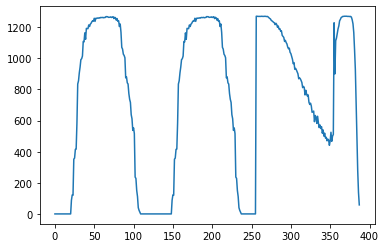

In [6]:
plt.plot(midi_count)
plt.show()

### interval_default 100

In [7]:
interval_count = [0 for i in range(687)]
cnt = 0
for mid in set1:
    encoded = encode_midi_JE(mid)
    temp = set(encoded)
    cnt += len(temp)
    for i in temp:
        interval_count[i]+=1

In [8]:
print("interval encoding =", cnt/len(set1))

interval encoding = 299.3559718969555


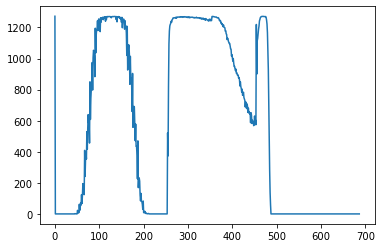

In [9]:
plt.plot(interval_count)
plt.show()

### interval logscale

In [20]:
logscale_count = [0 for i in range(487)]
cnt = 0
for mid in set1:
    encoded = encode_midi_JE(mid, logspace=True)
    temp = set(encoded)
    cnt += len(temp)
    for i in temp:
        logscale_count[i]+=1

In [21]:
print("interval encoding =", cnt/len(set1))

interval encoding = 232.92818110850897


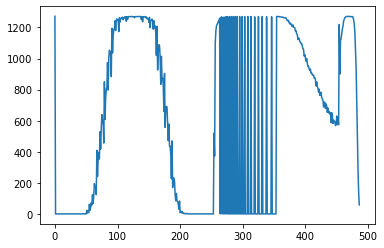

In [22]:
plt.plot(logscale_count)
plt.show()

## pop

### midi-like

In [10]:
midi_count_pop = [0 for i in range(388)]
cnt = 0
for mid in set2:
    encoded = encode_midi(mid)
    temp = set(encoded)
    cnt += len(temp)
    for i in temp:
        midi_count_pop[i]+=1

In [11]:
print("midi-like encoding =", cnt/len(set2))

midi-like encoding = 122.28492849284929


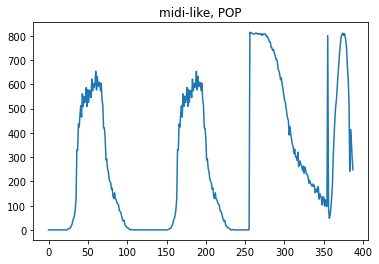

In [12]:
plt.plot(midi_count_pop)
plt.title("midi-like, POP")
plt.show()

### interval

In [13]:
interval_count_pop = [0 for i in range(487)]
cnt = 0
for mid in set2:
    encoded = encode_midi_JE(mid)
    temp = set(encoded)
    cnt += len(temp)
    for i in temp:
        interval_count_pop[i]+=1

In [14]:
print("interval encoding =", cnt/len(set2))

interval encoding = 154.1034103410341


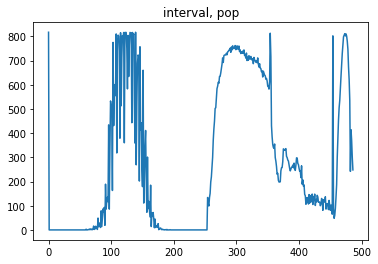

In [15]:
plt.plot(interval_count_pop)
plt.title("interval, pop")
plt.show()

### logscale

In [16]:
logscale_count = [0 for i in range(487)]
cnt = 0
for mid in set2:
    encoded = encode_midi_JE(mid, logspace=True)
    temp = set(encoded)
    cnt += len(temp)
    for i in temp:
        logscale_count[i]+=1

In [17]:
print("interval encoding =", cnt/len(set2))

interval encoding = 105.14631463146314


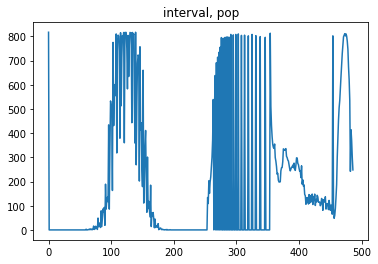

In [18]:
plt.plot(logscale_count)
plt.title("interval, pop")
plt.show()

# Pretty MIDI 갖고놀기

In [4]:
events = []
notes = []
file_path = '/home/bang/다운로드/maestro-v2.0.0-midi/maestro_midi/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.midi'
mid = pretty_midi.PrettyMIDI(midi_file=file_path)

In [10]:
mid.instruments[0].notes

[Note(start=1.023438, end=1.085938, pitch=74, velocity=92),
 Note(start=2.031250, end=2.095052, pitch=57, velocity=79),
 Note(start=2.533854, end=2.576823, pitch=62, velocity=86),
 Note(start=1.545573, end=2.598958, pitch=81, velocity=93),
 Note(start=3.024740, end=3.471354, pitch=74, velocity=82),
 Note(start=3.015625, end=3.529948, pitch=78, velocity=97),
 Note(start=3.518229, end=3.562500, pitch=73, velocity=73),
 Note(start=3.527344, end=3.576823, pitch=76, velocity=79),
 Note(start=3.661458, end=3.700521, pitch=71, velocity=78),
 Note(start=3.666667, end=3.714844, pitch=74, velocity=72),
 Note(start=3.796875, end=3.828125, pitch=69, velocity=76),
 Note(start=3.785156, end=3.856771, pitch=73, velocity=79),
 Note(start=3.928385, end=3.966146, pitch=67, velocity=78),
 Note(start=3.927083, end=3.984375, pitch=71, velocity=83),
 Note(start=4.063802, end=4.098958, pitch=66, velocity=76),
 Note(start=4.062500, end=4.113281, pitch=69, velocity=77),
 Note(start=4.195312, end=4.243490, pitc

In [14]:
mid.instruments[0].notes[0].pitch

74

In [17]:
pitch = set()
for i in range(len(mid.instruments[0].notes)):
    pitch.add(mid.instruments[0].notes[i].pitch)

In [21]:
print(pitch)

{33, 37, 38, 40, 41, 43, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86}


In [22]:
mid.instruments[0].notes[0].duration

AttributeError: 'Note' object has no attribute 'duration'

In [26]:
mid.instruments[0].notes[0]

[Note(start=1.023438, end=1.085938, pitch=74, velocity=92),
 Note(start=2.031250, end=2.095052, pitch=57, velocity=79),
 Note(start=2.533854, end=2.576823, pitch=62, velocity=86),
 Note(start=1.545573, end=2.598958, pitch=81, velocity=93),
 Note(start=3.024740, end=3.471354, pitch=74, velocity=82),
 Note(start=3.015625, end=3.529948, pitch=78, velocity=97),
 Note(start=3.518229, end=3.562500, pitch=73, velocity=73),
 Note(start=3.527344, end=3.576823, pitch=76, velocity=79),
 Note(start=3.661458, end=3.700521, pitch=71, velocity=78),
 Note(start=3.666667, end=3.714844, pitch=74, velocity=72),
 Note(start=3.796875, end=3.828125, pitch=69, velocity=76),
 Note(start=3.785156, end=3.856771, pitch=73, velocity=79),
 Note(start=3.928385, end=3.966146, pitch=67, velocity=78),
 Note(start=3.927083, end=3.984375, pitch=71, velocity=83),
 Note(start=4.063802, end=4.098958, pitch=66, velocity=76),
 Note(start=4.062500, end=4.113281, pitch=69, velocity=77),
 Note(start=4.195312, end=4.243490, pitc